In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import sys

sys.path.append("../../")

from tokenizers import Tokenizer
import sys

import matplotlib.pyplot as plt
import numpy as np
import collections
import torch

from ChEmbed.data import chembldb, smiles_dataset, chembed_tokenize, shakespeare_dataset
from ChEmbed.training import trainer
from ChEmbed.modules import simple_rnn
import attr

from ChEmbed import plots, utilities

from transformers.tokenization_utils_fast import PreTrainedTokenizerFast
from torch.utils.data import Dataset
from torch.utils.data import DataLoader

import torch
import attrs
from torch import nn, optim


Disabling PyTorch because PyTorch >= 2.1 is required but found 2.0.0
None of PyTorch, TensorFlow >= 2.0, or Flax have been found. Models won't be available and only tokenizers, configuration and file/data utilities can be used.
None of PyTorch, TensorFlow >= 2.0, or Flax have been found. Models won't be available and only tokenizers, configuration and file/data utilities can be used.


In [34]:
def simple_generate(prefix, num_chars, model, char_to_idx_mapping, idx_to_char_mapping, temperature = 0.0, device=None):
    """
    Simple character-by-character generation function.
    """

    def decode_indices_to_string(encoded_indices: list, idx_to_char_mapping: dict[int, str]):
        decoded = ''.join([idx_to_char_mapping[int(inx)] for inx in encoded_indices])
        return decoded

    def encode_string_to_indices(smiles_string: str, char_to_idx_mapping: dict[str, int]):
        encoded = [char_to_idx_mapping[c] for c in smiles_string]
        return encoded

    model.eval()
    generated = prefix
    
    with torch.no_grad():
        for i in range(num_chars):
            # Encode current text
            encoded = torch.nn.functional.one_hot(torch.tensor(encode_string_to_indices(generated, char_to_idx_mapping)), num_classes=len(char_to_idx_mapping))
            input_tensor = torch.tensor(encoded, device=device, dtype=torch.float32)
            
            # Get prediction
            output = model(input_tensor.unsqueeze(0))  # Add batch dim
            
            # Get most likely next token
            if temperature > 0:
                # Apply temperature scaling
                output = output / temperature
                probabilities = torch.softmax(output, dim=-1)
                next_token = torch.multinomial(probabilities[0, -1, :], num_samples=1).item()
            else:
                # Default to argmax if temperature is 0
                next_token = output[0, -1, :].argmax().item()
            
            # Decode and append
            next_char = decode_indices_to_string([next_token], idx_to_char_mapping)
            generated += next_char
            
            # print(f"Step {i+1}: Added '{next_char}' -> '{generated}'")
            
    return generated

In [4]:
def decode_indices_to_string(encoded_indices: list, idx_to_char_mapping: dict[int, str]):
    decoded = ''.join([idx_to_char_mapping[int(inx)] for inx in encoded_indices])
    return decoded

def encode_string_to_indices(smiles_string: str, char_to_idx_mapping: dict[str, int]):
    encoded = [char_to_idx_mapping[c] for c in smiles_string]
    return encoded

In [37]:
# shakespeare_raw = ' '.join(open("../raw-data/shakespeare.txt", 'r', encoding='utf-8').read().split('\n'))
shakespeare_raw = open("../raw-data/shakespeare.txt", 'r', encoding='utf-8').read()

In [73]:
dataset = shakespeare_dataset.characterLevelShakespeare(
    all_text = shakespeare_raw,
    length = 32
)

In [93]:
model = simple_rnn.simpleRNN(
    # Mandatory
    num_hiddens = 512,
    vocab_size = len(dataset.characters),
    # tuning
    learning_rate = 0.001,
    weight_decay = 1e-4,
    num_layers = 3
)

In [83]:
model_trainer = trainer.Trainer(max_epochs=64, init_random=None, clip_grads_norm=3.0)
model_trainer.fit(model, dataset)

Epoch 1/64: Train Loss: 1.9698, Val Loss: 1.6765
Epoch 2/64: Train Loss: 1.5996, Val Loss: 1.5885
Epoch 3/64: Train Loss: 1.5301, Val Loss: 1.5690
Epoch 4/64: Train Loss: 1.4967, Val Loss: 1.5475
Epoch 5/64: Train Loss: 1.4762, Val Loss: 1.5341
Epoch 6/64: Train Loss: 1.4613, Val Loss: 1.5315
Epoch 7/64: Train Loss: 1.4500, Val Loss: 1.5163
Epoch 8/64: Train Loss: 1.4417, Val Loss: 1.5156
Epoch 9/64: Train Loss: 1.4342, Val Loss: 1.5098
Epoch 10/64: Train Loss: 1.4274, Val Loss: 1.5104
Epoch 11/64: Train Loss: 1.4220, Val Loss: 1.5009
Epoch 12/64: Train Loss: 1.4177, Val Loss: 1.5070
Epoch 13/64: Train Loss: 1.4131, Val Loss: 1.4994
Epoch 14/64: Train Loss: 1.4096, Val Loss: 1.4982
Epoch 15/64: Train Loss: 1.4064, Val Loss: 1.5011
Epoch 16/64: Train Loss: 1.4032, Val Loss: 1.4980
Epoch 17/64: Train Loss: 1.4002, Val Loss: 1.4921
Epoch 18/64: Train Loss: 1.3980, Val Loss: 1.4909
Epoch 19/64: Train Loss: 1.3955, Val Loss: 1.4907
Epoch 20/64: Train Loss: 1.3934, Val Loss: 1.4863
Epoch 21/

In [97]:
print(simple_generate("Claudius:", 100, model, dataset.char_to_idx, dataset.idx_to_char, temperature=1.5, device='cuda'))

/tmp/ipykernel_133582/2132123058.py:21: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  input_tensor = torch.tensor(encoded, device=device, dtype=torch.float32)


RuntimeError: Input and parameter tensors are not at the same device, found input tensor at cuda:0 and parameter tensor at cpu

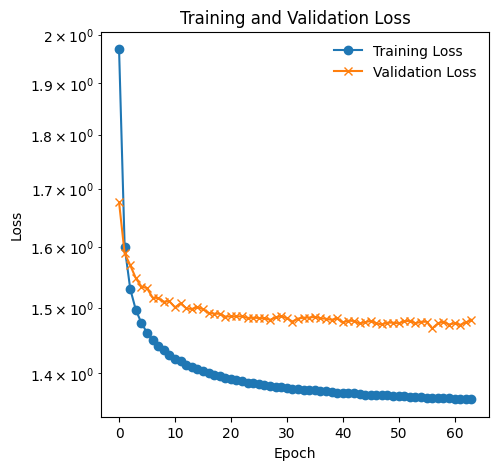

In [85]:
losses = utilities.extract_training_losses(model_trainer.metadata)
fig, ax = plots.plot_training_validation_loss(losses['avg_train_losses'], losses['avg_val_losses'])
ax.set_yscale('log')

In [86]:
# Let's test a simple batch to understand what's happening
test_batch = next(iter(dataset.train_dataloader()))
print("Input shape:", test_batch[0].shape)
print("Target shape:", test_batch[1].shape)

# Move to device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
test_input = test_batch[0].to(device)
test_target = test_batch[1].to(device)

# Test model forward pass
model.eval()
with torch.no_grad():
    output = model(test_input)
    print("Output shape:", output.shape)
    
    # Check if gradients are flowing properly by testing loss
    loss = model.training_step([test_input, test_target])
    print("Loss value:", loss.item())
    
    # Let's see what the actual predictions look like
    preds = output.reshape(-1, len(dataset.characters))
    targets = test_target.reshape(-1)
    print("Preds shape:", preds.shape)
    print("Targets shape:", targets.shape)
    print("Sample predictions (first 10 probs):", torch.softmax(preds[:10], dim=1))
    print("Sample target indices (first 10):", targets[:10])
    
    # Check if predictions are just random/uniform
    print("Are predictions roughly uniform? (should be ~1/vocab_size)")
    mean_probs = torch.softmax(preds, dim=1).mean(dim=0)
    print("Mean probabilities across vocab:", mean_probs[:10])
    print("Expected uniform prob:", 1.0/len(dataset.characters))

Input shape: torch.Size([128, 31, 84])
Target shape: torch.Size([128, 31])
Output shape: torch.Size([128, 31, 84])
Loss value: 1.293547511100769
Preds shape: torch.Size([3968, 84])
Targets shape: torch.Size([3968])
Sample predictions (first 10 probs): tensor([[7.6064e-04, 5.3947e-05, 3.5710e-03, 1.3728e-05, 2.5448e-05, 1.1104e-02,
         3.7910e-01, 1.6492e-02, 6.5295e-02, 9.9822e-03, 2.3556e-05, 5.6298e-02,
         2.2327e-02, 7.0285e-03, 3.0562e-05, 1.0323e-05, 1.8616e-03, 2.3812e-03,
         6.8865e-03, 2.5878e-02, 4.2529e-05, 1.4947e-05, 7.5945e-05, 1.7665e-03,
         1.0521e-02, 7.7659e-03, 2.5454e-05, 3.4138e-03, 1.4623e-05, 2.5096e-02,
         8.4331e-03, 9.9489e-03, 4.2755e-03, 2.4988e-05, 9.2273e-06, 6.4999e-04,
         4.0768e-05, 2.4791e-05, 4.7395e-04, 9.9262e-04, 2.4562e-05, 1.0521e-03,
         3.1456e-02, 2.7616e-03, 1.3102e-03, 1.0353e-02, 9.7878e-03, 4.1436e-03,
         2.9762e-05, 4.2440e-03, 1.5002e-05, 7.2652e-04, 1.1266e-03, 2.6571e-05,
         1.0112e-04

In [87]:
# Simple test - are predictions changing or stuck?
test_batch = next(iter(dataset.train_dataloader()))
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
test_input = test_batch[0].to(device)
test_target = test_batch[1].to(device)

print("Vocab size:", len(dataset.characters))
print("Expected uniform probability:", 1.0/len(dataset.characters))

model.eval()
with torch.no_grad():
    output = model(test_input)
    preds = torch.softmax(output.reshape(-1, len(dataset.characters)), dim=1)
    
    # Check first prediction probabilities
    first_pred = preds[0]
    print("First prediction probabilities (should be diverse if learning):")
    print("Max prob:", first_pred.max().item())
    print("Min prob:", first_pred.min().item())
    print("Std dev:", first_pred.std().item())
    
    # Check if all predictions are the same (stuck)
    all_same = torch.allclose(preds[0], preds[1], atol=1e-6)
    print("Are all predictions identical?", all_same)

Vocab size: 84
Expected uniform probability: 0.011904761904761904
First prediction probabilities (should be diverse if learning):
Max prob: 0.3791000545024872
Min prob: 9.227306691172998e-06
Std dev: 0.042424771934747696
Are all predictions identical? False


In [91]:
# Let's diagnose the specific issues with training
import torch
import math

# Check theoretical minimum loss
vocab_size = len(dataset.characters)
theoretical_min_loss = -math.log(1.0/vocab_size)
print(f"Vocab size: {vocab_size}")
print(f"Theoretical minimum loss (random guessing): {theoretical_min_loss:.4f}")
print(f"Current loss (~2.5) vs theoretical min: {2.5/theoretical_min_loss:.2f}x higher")

# Test gradients
test_batch = next(iter(dataset.train_dataloader()))
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
test_input = test_batch[0].to(device)
test_target = test_batch[1].to(device)

# Create a fresh model for testing
diagnostic_model = simple_rnn.simpleRNN(
    num_hiddens=64,
    vocab_size=len(dataset.characters),
    learning_rate=0.01,  # Note: using 0.01, not 0.1
    weight_decay=0.01
)
diagnostic_model.to(device)

# Check gradient magnitudes
diagnostic_model.train()
optimizer = diagnostic_model.configure_optimizers()

print("\n=== Gradient Analysis ===")
for step in range(3):
    optimizer.zero_grad()
    loss = diagnostic_model.training_step([test_input, test_target])
    loss.backward()
    
    total_norm = 0
    param_count = 0
    for name, param in diagnostic_model.named_parameters():
        if param.grad is not None:
            param_norm = param.grad.data.norm(2)
            total_norm += param_norm.item() ** 2
            param_count += 1
            print(f"Step {step+1} - {name}: grad_norm = {param_norm:.6f}")
    
    total_norm = total_norm ** (1. / 2)
    print(f"Step {step+1} - Total gradient norm: {total_norm:.6f}")
    print(f"Step {step+1} - Loss: {loss.item():.6f}")
    
    optimizer.step()
    print()

# Check if predictions are collapsing to uniform distribution
print("=== Prediction Analysis ===")
diagnostic_model.eval()
with torch.no_grad():
    output = diagnostic_model(test_input[:1])  # Just one sample
    probs = torch.softmax(output.reshape(-1, vocab_size), dim=1)
    
    # Check entropy - should be high if uniform, low if confident
    entropy = -(probs * torch.log(probs + 1e-10)).sum(dim=1).mean()
    max_entropy = math.log(vocab_size)
    
    print(f"Average prediction entropy: {entropy:.4f}")
    print(f"Maximum possible entropy: {max_entropy:.4f}")
    print(f"Entropy ratio (1.0 = completely uniform): {entropy/max_entropy:.4f}")
    
    # Check if model is just outputting the same thing
    std_across_vocab = probs.std(dim=1).mean()
    print(f"Std dev across vocabulary: {std_across_vocab:.6f}")
    print(f"Expected std for uniform dist: {(1/vocab_size * (1-1/vocab_size))**0.5:.6f}")

Vocab size: 84
Theoretical minimum loss (random guessing): 4.4308
Current loss (~2.5) vs theoretical min: 0.56x higher

=== Gradient Analysis ===


RuntimeError: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic because it uses CuBLAS and you have CUDA >= 10.2. To enable deterministic behavior in this case, you must set an environment variable before running your PyTorch application: CUBLAS_WORKSPACE_CONFIG=:4096:8 or CUBLAS_WORKSPACE_CONFIG=:16:8. For more information, go to https://docs.nvidia.com/cuda/cublas/index.html#cublasApi_reproducibility